# 安装必要的环境

In [1]:
!pip install accelerate datasets -q

# 0、加载训练好的基座模型（qwen2.5-1.5B）

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os
import numpy as np
device = "cuda" # the device to load the model onto
model_name = "Qwen2___5-1___5B"
model_path = f'Qwen/{model_name}'

# 获取可用GPU设备的数量和内存信息
gpu_memory = {i: torch.cuda.get_device_properties(i).total_memory for i in range(torch.cuda.device_count())}
# 加载模型
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="balanced",
        max_memory={i: f"{gpu_memory[i] // (1024 ** 3)}GB" for i in range(len(gpu_memory))}
    )
except Exception as e:
    print(f"Failed to load model from {model_path}: {e}")
    raise
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [2]:
tokenizer.added_tokens_decoder

{151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151647: AddedToken("<|object_ref_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151648: AddedToken("<|box_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151649: AddedToken("<|box_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151650: AddedToken("<|quad_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151651: AddedToken("<|quad_end|>", rstrip=False, lstrip=

In [3]:
model.model.embed_tokens

Embedding(151936, 1536)

In [4]:
# 查看分词器中的special token
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [5]:
tokenizer.all_special_tokens

['<|endoftext|>',
 '<|im_start|>',
 '<|im_end|>',
 '<|object_ref_start|>',
 '<|object_ref_end|>',
 '<|box_start|>',
 '<|box_end|>',
 '<|quad_start|>',
 '<|quad_end|>',
 '<|vision_start|>',
 '<|vision_end|>',
 '<|vision_pad|>',
 '<|image_pad|>',
 '<|video_pad|>']

In [6]:
tokenizer.all_special_ids

[151643,
 151644,
 151645,
 151646,
 151647,
 151648,
 151649,
 151650,
 151651,
 151652,
 151653,
 151654,
 151655,
 151656]

In [7]:
model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "max_new_tokens": 2048
}

## 0.2 重设模型的generation_config文件

In [8]:
model.generation_config.do_sample = True
model.generation_config.eos_token_id = [151645, 151643]
model.generation_config.pad_token_id = 151643
model.generation_config.temperature = 0.7
model.generation_config.top_p = 0.8
model.generation_config.top_k = 20
model.generation_config.transformers_version = "4.37.0"
model.generation_config.repetition_penalty = 1.05

model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_new_tokens": 2048,
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

# 1、 新增`reasoning`special token + 同步调整模型的`embedding`层
- reasoning特殊标签格式：  **<|reasoning|>**
- 模型的分词器、嵌入层和lm_head均适配新增一个特殊token：<|reasoning|>

In [9]:
# 查看模型嵌入层
model.model.embed_tokens

Embedding(151936, 1536)

In [10]:
# 查看模型的vocab_size
tokenizer.vocab_size

151643

In [11]:
len(tokenizer)

151665

In [12]:
len(tokenizer) - tokenizer.vocab_size

22

In [13]:
import numpy as np
{k:v for k,v in zip([i for i in np.arange(tokenizer.vocab_size, len(tokenizer))], [tokenizer.decode(i) for i in np.arange(tokenizer.vocab_size, len(tokenizer))])}

{151643: '<|endoftext|>',
 151644: '<|im_start|>',
 151645: '<|im_end|>',
 151646: '<|object_ref_start|>',
 151647: '<|object_ref_end|>',
 151648: '<|box_start|>',
 151649: '<|box_end|>',
 151650: '<|quad_start|>',
 151651: '<|quad_end|>',
 151652: '<|vision_start|>',
 151653: '<|vision_end|>',
 151654: '<|vision_pad|>',
 151655: '<|image_pad|>',
 151656: '<|video_pad|>',
 151657: '<tool_call>',
 151658: '</tool_call>',
 151659: '<|fim_prefix|>',
 151660: '<|fim_middle|>',
 151661: '<|fim_suffix|>',
 151662: '<|fim_pad|>',
 151663: '<|repo_name|>',
 151664: '<|file_sep|>'}

可见，151643 - 151664 ，这22个元素是特殊token (有些甚至还是预留的适配多模态以及工具利用的特殊token标记)

In [14]:
# 因为我们导入的是基座模型（预训练模型），除了<|endoftext|> (<|endoftext|>嵌入在预训练过程中也会被训练) ，其他的特殊token应该都是随机初始化的，我们查看从第二行元素开始，嵌入是否都相同？
special_tensorweight = model.model.embed_tokens.weight[tokenizer.vocab_size+1: len(tokenizer)].detach()
print(special_tensorweight)
print(f'tensor size: {special_tensorweight.shape}')
# 选择第1个张量作为基准
reference_tensor = special_tensorweight[0]

# 定义一个容差值，用于比较浮点数是否相等
tolerance = 1e-4

all_same = all(torch.allclose(tensor, reference_tensor, atol=tolerance) for tensor in special_tensorweight)

if all_same:
  print("所有张量都相同（在容差范围内）")
else:
  print("张量不都相同")

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)
tensor size: torch.Size([21, 1536])
所有张量都相同（在容差范围内）


In [15]:
# 那么 151665 - 151935 是什么token呢， 我们解码一下
tokenizer.decode(torch.tensor(np.arange(len(tokenizer), model.model.embed_tokens.weight.detach().shape[0]).tolist()))

''

可以看到这些都是无用的token（空字符串），至于为什么需要pad这些token，找到的一篇答复：https://huggingface.co/Qwen/Qwen1.5-72B-Chat/discussions/1#662883f568adf59b07b176d2

In [16]:
model.model.embed_tokens.weight.detach()[len(tokenizer):, :]

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)

可以看到，这些【151665 - 151935】的无用token也和上面**【151644 - 151664 】**的特殊token的嵌入相同

In [17]:
model.lm_head.weight[tokenizer.vocab_size+1:].detach()
# 即 【151644 - 151935】的token嵌入都相同

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)

In [18]:
# 再查看最后的`lm_head`层中151644之后的张量是否都相同
print(model.lm_head.weight[tokenizer.vocab_size+1:].detach())
special_token_lmhead_weight = model.lm_head.weight[tokenizer.vocab_size+1:].detach()  #除了<|endoftext|>，这个特殊token在预训练阶段也会被训练
# 选择一个张量作为基准
reference_tensor = special_token_lmhead_weight[0]

# 定义一个容差值，用于比较浮点数是否相等
tolerance = 1e-4

all_same = all(torch.allclose(tensor, reference_tensor, atol=tolerance) for tensor in special_token_lmhead_weight)

if all_same:
  print("所有张量都相同（在容差范围内）")
else:
  print("张量不都相同")

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)
所有张量都相同（在容差范围内）


## 1.1、增加`<|reasoning|>`这个special token

In [19]:
print(f"before add new special token, the Vocabulary Size is: {len(tokenizer)}")
new_special_token = "<|reasoning|>"
tokenizer.add_special_tokens({"additional_special_tokens": [new_special_token]})
print(f"after add new special token, the Vocabulary Size is: {len(tokenizer)}")

before add new special token, the Vocabulary Size is: 151665
after add new special token, the Vocabulary Size is: 151666


In [20]:
# check the id of th new token
new_token_id = tokenizer.convert_tokens_to_ids(new_special_token)
print(f"the id of {new_special_token} is: {new_token_id}")

the id of <|reasoning|> is: 151665


## 1.2、新增 `<|reasoning|>` 该special token后，还需要同步调整模型的`embedding`层(可以不用执行)

In [ ]:
model.resize_token_embeddings(len(tokenizer))
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151666, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

可以看到 嵌入层`embed_tokens`和最后的输出层`lm_head`都新增加了一个维度，变为了`151666`，我们接下来分别查看下新增加的这个维度的嵌入和最后的分类头的映射weight

In [ ]:
model.model.embed_tokens.weight[-22:]

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

In [ ]:
model.lm_head.weight[-22:]

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

- 看样子，qwen2系列的小模型的确是使用了参数共享tie_weights方法（embedding层和最后的lm_head层权值共享或者说权重绑定）以压缩参数量
- 没记错的话，qwen系列是只有小模型使用了参数共享方法，大些体量的模型并没有使用共享方法


In [21]:
# 测试编解码码效果
input_text = "this is a test with a new special token: <|reasoning|>. let's task it"
# 编码
input_ids = tokenizer.encode(input_text, return_tensors="pt")
# 再解码回去
tokenizer.decode(input_ids[0]) == input_text

True

In [22]:
tokenizer.decode(input_ids[0])

"this is a test with a new special token: <|reasoning|>. let's task it"

In [23]:
tokenizer.encode("<|reasoning|>", return_tensors="pt")

tensor([[151665]])

In [24]:
model.model.embed_tokens

Embedding(151936, 1536)

## 以上我们就完成了对模型的**分词器**、**嵌入层**和**lm_head**均适配新增一个特殊token：**<|reasoning|>**

# 2、定义模型训练过程中的超参

In [25]:
from dataclasses import dataclass
@dataclass
class modelConfig:
    max_length:int = 3000
    batch_size:int = 1
    gradient_accumulation_steps:int = 8
    log_iter:int = 400
    max_lr:float = 2e-5
    min_lr:float = 2e-6
    warmup_steps:int = 1000

# 3、导入训练数据并开启训练

In [26]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [27]:
import datasets
reasoning_data = datasets.load_dataset('KingNish/reasoning-base-20k')

In [28]:
# prompt: save the dataset into local file
reasoning_data.save_to_disk("./reasoning_data")

Saving the dataset (0/1 shards):   0%|          | 0/19944 [00:00<?, ? examples/s]

In [29]:
reasoning_data['train']

Dataset({
    features: ['user', 'reasoning', 'assistant', 'template', 'conversations'],
    num_rows: 19944
})

In [30]:
# 全部是单轮对话
max([len(i) for i in reasoning_data['train']['conversations']]) == 3

True

In [31]:
reasoning_data['train'] = reasoning_data['train'].map(lambda x: {
    **x,
    'user_template': "".join(["<|im_start|>user\n", x['user'], "<|im_end|>\n"]),
    'reasoning_template': "".join(["<|im_start|><|reasoning|>\n", x['reasoning'], "<|im_end|>\n"]),
    'assistant_template': "".join(["<|im_start|>assistant\n", x['assistant'], "<|im_end|>\n"]),
    'template_new': "".join([       "<|im_start|>system\nYou are a helpful assistant<|im_end|>\n", #添加系统提示词
                        "<|im_start|>user\n", x['user'], "<|im_end|>\n",
                        "<|im_start|><|reasoning|>\n", x['reasoning'], "<|im_end|>\n",
                        "<|im_start|>assistant\n", x['assistant'], "<|im_end|>\n"])
})

In [32]:
reasoning_data['train']

Dataset({
    features: ['user', 'reasoning', 'assistant', 'template', 'conversations', 'user_template', 'reasoning_template', 'assistant_template', 'template_new'],
    num_rows: 19944
})

In [33]:
# 探查数据
print(reasoning_data['train']['template_new'][0])

<|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Prove that the difference between two consecutive cubes cannot be divisible by 5, using the fact that the only possible remainders when a cube is divided by 5 are 0, 1, and -1.<|im_end|>
<|im_start|><|reasoning|>
Let's break down the problem step by step and reason through it.

**Understanding the Problem**

The problem asks us to prove that the difference between two consecutive cubes cannot be divisible by 5. To approach this problem, we need to understand what consecutive cubes are and how we can represent them mathematically.

Consecutive cubes are cubes of consecutive integers. For example, if we take the integer 2, its cube is 2^3 = 8. The next consecutive integer is 3, and its cube is 3^3 = 27. So, the difference between these two consecutive cubes is 27 - 8 = 19.

**Representing Consecutive Cubes Mathematically**

Let's represent the two consecutive cubes as n^3 and (n+1)^3, where n is an integer. The dif

In [34]:
# 确保编解码前后的文本对齐
assert tokenizer.decode(tokenizer.encode(reasoning_data['train']['template_new'][0], return_tensors="pt")[0]) == reasoning_data['train']['template_new'][0]

In [35]:
print(tokenizer.decode(tokenizer.encode(reasoning_data['train']['template_new'][0], return_tensors="pt", truncation=True, max_length=modelConfig.max_length)[0]))

<|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Prove that the difference between two consecutive cubes cannot be divisible by 5, using the fact that the only possible remainders when a cube is divided by 5 are 0, 1, and -1.<|im_end|>
<|im_start|><|reasoning|>
Let's break down the problem step by step and reason through it.

**Understanding the Problem**

The problem asks us to prove that the difference between two consecutive cubes cannot be divisible by 5. To approach this problem, we need to understand what consecutive cubes are and how we can represent them mathematically.

Consecutive cubes are cubes of consecutive integers. For example, if we take the integer 2, its cube is 2^3 = 8. The next consecutive integer is 3, and its cube is 3^3 = 27. So, the difference between these two consecutive cubes is 27 - 8 = 19.

**Representing Consecutive Cubes Mathematically**

Let's represent the two consecutive cubes as n^3 and (n+1)^3, where n is an integer. The dif

## 3.1、训练数据转化成tokenid：str -> tokenid

In [36]:
reasoning_data['train'] = reasoning_data['train'].map(lambda x: {
    **x,
    'truncated_token_id': tokenizer.encode(x['template_new'], truncation=True, max_length=modelConfig.max_length)
})

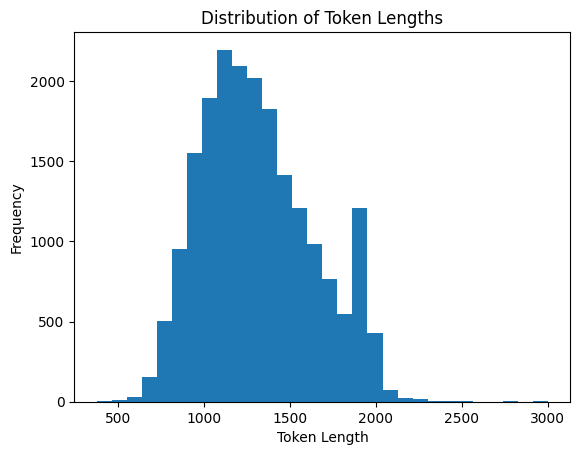

In [37]:
import matplotlib.pyplot as plt

token_lengths = [len(i) for i in reasoning_data['train']['truncated_token_id']]

plt.hist(token_lengths, bins=30)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

In [38]:
reasoning_data['train']

Dataset({
    features: ['user', 'reasoning', 'assistant', 'template', 'conversations', 'user_template', 'reasoning_template', 'assistant_template', 'template_new', 'truncated_token_id'],
    num_rows: 19944
})

In [39]:
assert tokenizer.decode(torch.tensor(reasoning_data['train'][0]['truncated_token_id'])) == reasoning_data['train'][0]['template_new']

## 3.2、使用设置的训练超参数

In [40]:
batch_size = modelConfig.batch_size
gradient_accumulation_steps = modelConfig.gradient_accumulation_steps
log_iter = modelConfig.log_iter
max_lr = modelConfig.max_lr
min_lr = modelConfig.min_lr
warmup_steps = modelConfig.warmup_steps
total_steps = len(reasoning_data['train'])//batch_size
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=max_lr)
trainable_parameters_num = sum(p.numel() for p in filter(lambda p:p.requires_grad, model.parameters()))  ##全参微调

## 3.3、配置logging日志记录模型训练过程

In [41]:
##配置logging
import time
with open(f"./{model_name}-SFT_log.txt", "a") as my_file:
  my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, batch_size:{batch_size}, trainable_parameters_num:{trainable_parameters_num}, warmup_steps:{warmup_steps}, max_lr:{max_lr}, min_lr:{min_lr}, gradient_accumulation_steps:{gradient_accumulation_steps}\n')
#定义一个日志记录函数
def log_call(iters, iters_average_loss):
  with open(f"./{model_name}-SFT_log.txt", "a") as my_file:
    my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, iters_average_Loss:{iters_average_loss:.4f}\n')

## 3.4、学习率设置：余弦衰减学习率

In [42]:
def linear_warmup(current_step, warmup_steps, max_lr):
    if current_step < warmup_steps:
        return max_lr * current_step / warmup_steps
    else:
        return max_lr

def cosine_decay(current_step, warmup_steps, total_steps, max_lr, min_lr):
    if current_step < warmup_steps:
        return linear_warmup(current_step, warmup_steps, max_lr)
    else:
        progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
        decay = 0.5 * (1 + np.cos(np.pi * progress))
        return (max_lr - min_lr) * decay + min_lr

## 3.5、掩码设置
- SFT和预训练的区别核心就是掩码掉“问题”部分的损失，而【只看“回答”部分的损失】，并仅基于回答部分的损失进行优化
- 实现方式：【构造损失掩码】，仅针对每轮对话（含多轮）的模型“输出”部分（也就是回答部分，**本处默认包含reasoning部分**）进行损失计算

In [43]:
# 设置问题部分的掩码函数，用于执行仅针对回答部分（此处默认包含reasoning部分）才计算损失
def return_answer_mask(input_ids):
  assistant_answer_mask = torch.zeros_like(input_ids) #0初始化
  for i in range(input_ids.shape[0]):
        ## user部分的结尾\n: \n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】，关于聊天模版可阅读这篇文章：https://huggingface.co/blog/chat-templates
        i_user_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[1::3]]   #第1个im_end开始
        ## assistant部分的结尾\n：\n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】
        i_assistant_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[3::3]] #第3个im_end开始

        if len(i_user_end_list)==len(i_assistant_end_list):
            for user_end, assistant_end in zip(i_user_end_list, i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1 #+3的操作，【这个地方需要根据不同模型的不同聊天模版自定义更改】
        elif len(i_user_end_list)==len(i_assistant_end_list)+1==1:  ##单轮问答,且回答部分未结尾就被截断了
            assistant_answer_mask[i][i_user_end_list[0]+3:]=1  ##会把右补的padding token也标记为1，所以后面还需要再结合padding mask以过滤padding
        elif len(i_user_end_list)==len(i_assistant_end_list)+1:   ##兼顾多轮问答
            assistant_answer_mask[i][i_user_end_list[-1]+3:]=1
            for user_end, assistant_end in zip(i_user_end_list[:-1], i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1
        else:
            continue  ##跳出当前循环，继续下一次循环
  return assistant_answer_mask

## 3.6、开启SFT微调训练

In [ ]:
model.train()
train_loss_list = []
model.zero_grad() ##clear gradients at the start of training
ignore_iters_count = 0
for iters in range(len(reasoning_data['train'])//batch_size):
    ## 获取批次数据
    chosen_batch_inputids = reasoning_data['train'][iters*batch_size:(iters+1)*batch_size]['truncated_token_id']

    ## 对该批次数据进行padding,以并行计算，首先计算该批次的最大token长度
    chosen_max_dim = max([len(i) for i in chosen_batch_inputids])

    ### 训练数据padding填充
    chosen_batch_inputids_padding_list = []
    for i in range(batch_size):
        chosen_batch_inputids_padding_list.append(torch.nn.functional.pad(torch.tensor(chosen_batch_inputids[i]), (0, chosen_max_dim - len(chosen_batch_inputids[i])), mode='constant', value=model.generation_config.eos_token_id[-1]).tolist()) #右补
    chosen_batch_inputids_tensor = torch.tensor(chosen_batch_inputids_padding_list)

    ## 构建训练数据：x->y ,下一个单词预测
    chosen_x = chosen_batch_inputids_tensor[:, :-1].to(device)
    chosen_y = chosen_batch_inputids_tensor[:, 1:].to(device)

    ## 构建掩码判别矩阵（paddding mask & answer_mask, padding mask用于执行对padding的token不计算损失，answer_mask用于执行仅针对回答部分才计算损失），总之，就是确认哪些tokens的logit需要"忽视"掉
    ### 【padding mask】
    chosen_padding_mask = torch.where(chosen_y==model.generation_config.eos_token_id[-1], 0, 1)
    ### 【answer_mask】
    chosen_assistant_answer_mask = return_answer_mask(chosen_x)
    ### 【paddingmask & answermask】方便使用掩码判别矩阵对logit和y进行过滤->:我们只关注【回答】部分的损失，不关注问题部分的损失
    chosen_assistant_answer_mask = (chosen_assistant_answer_mask&chosen_padding_mask)

    if chosen_assistant_answer_mask.sum(dim=-1).min().item()==0:##如果该批次里有的问答数据在数据截取时，回答部分存在没有数据的情况（问题太长了，导致还未采集到回答部分的token就被硬截断了），那么该批次数据不再训练
      #print(f'不处理第{iters+1}批次数据')
      ignore_iters_count+=1
      continue  #跳出当前循环

    ## 执行训练数据的模型前向推理，计算logits
    chosen_logits = model(chosen_x).logits
    torch.cuda.empty_cache() #清除非必要的显存占用，但会导致速度变慢
    torch.cuda.ipc_collect()

    ## Compute Chosen_Answer_Loss，计算训练数据的回答部分的损失, batch_loss的shape_size:[batch_size]
    batch_loss = torch.mul((torch.gather(torch.log(torch.softmax(chosen_logits, dim=-1)), dim=-1, index=chosen_y.unsqueeze(2))*(-1)).squeeze(2), chosen_assistant_answer_mask).sum(dim=-1) / chosen_assistant_answer_mask.sum(dim=-1)

    ## Calculate the Final Loss, 只是新增了梯度积累的操作
    loss = torch.nanmean(batch_loss)/(gradient_accumulation_steps)

    loss.backward() ##反向传播计算梯度

    # Compute the learning rate for the current step
    lr = cosine_decay(iters, warmup_steps, total_steps, max_lr, min_lr)

    # Update the learning rate for the AdamW optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if (iters+1)%gradient_accumulation_steps==0 or (iters+1)==(len(reasoning_data['train'])//batch_size):
        optimizer.step() #update weights after gradients accumulation
        ##at last, clear gradients
        optimizer.zero_grad() #clear gradients after updating, in this case equal to model.zero_grad()

    train_loss_list.append(loss.item()*gradient_accumulation_steps)

    if (iters+1)%log_iter==0 or (iters+1)==(len(reasoning_data['train'])//batch_size):
      print(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, last_{log_iter}_iters_average_train_Loss:{np.nanmean(train_loss_list[-log_iter:]):.4f}') ##避免空值影响
      log_call(iters, np.nanmean(train_loss_list[-log_iter:]))
    #过程中，保存模型
    if ((iters+1)*(modelConfig.batch_size))%2000==0:
        torch.save(model.state_dict(),f"./{model_name}_SFT.pth")

print("Totally Completed!")
print(f'共计忽略{ignore_iters_count}个批次数据')

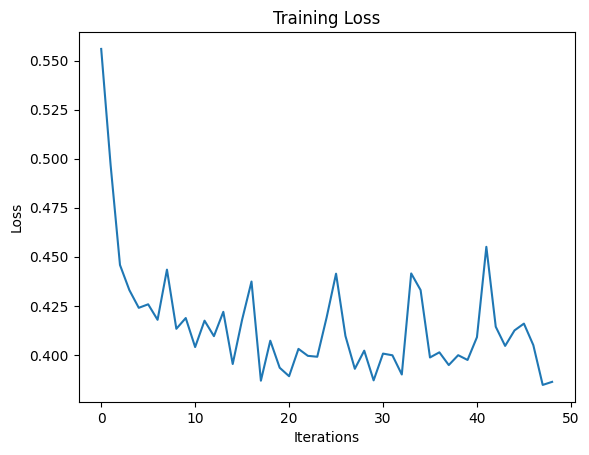

In [ ]:
import matplotlib.pyplot as plt
interval = 400
# Assuming train_loss_list contains the loss values from your training
plt.plot([np.nanmean(train_loss_list[i*interval:(i+1)*interval]) for i in range(len(train_loss_list)//interval)])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 3.7、保存模型

In [ ]:
torch.save(model.state_dict(),f"./{model_name}_SFT.pth")

# 4、测试模型问答效果

In [ ]:
from typing import List, Dict

def new_apply_chat_template(history:List[Dict[str, str]], add_reasoning_generation_prompt:bool=True, add_assistant_generation_prompt:bool=False):
  if add_reasoning_generation_prompt:
    return "".join([f"<|im_start|>{i['role']}\n{i['content']}<|im_end|>\n" for i in history]) + "<|im_start|><|reasoning|>\n"
  if add_assistant_generation_prompt:
    return "".join([f"<|im_start|>{i['role']}\n{i['content']}<|im_end|>\n" for i in history]) + "<|im_start|>assistant\n"

In [ ]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|reasoning|>']}

In [ ]:
from IPython.display import Markdown, display

history = []
history.append({"role": "system", "content": "You are a helpful assistant"})
while True:
    question = input('User：' + '\n')
    print(question)
    print('\n')
    history.append({"role": "user", "content": question})

    input_text = new_apply_chat_template(
            history,
            add_reasoning_generation_prompt=True
        )
    model_inputs = tokenizer([input_text], return_tensors="pt").to(device)

    if model_inputs.input_ids.size()[1]>32000:
        break

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=3000
    )

    if len(generated_ids)>32000:
        break

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

    reasoning_response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    history.append({"role": "<|reasoning|>", "content": reasoning_response})
    print('reasoning:\n')
    #print(response)
    display(Markdown(reasoning_response))
    print("------------")
    print('\n')

    input_text = new_apply_chat_template(
            history,
            add_assistant_generation_prompt=True
        )
    model_inputs = tokenizer([input_text], return_tensors="pt").to(device)

    if model_inputs.input_ids.size()[1]>32000:
        break

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=3000
    )

    if len(generated_ids)>32000:
        break

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

    assistant_response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    history.append({"role": "assistant", "content": assistant_response})
    print('assistant:\n')
    display(Markdown(assistant_response))
    print("------------")

print("超过模型字数上线，已退出")

User：
Please find all prime numbers within 0-10
Please find all prime numbers within 0-10


reasoning:



To tackle this problem, let's break it down into manageable parts and reason through each step.

**Understanding the Problem**

The user is asking for all prime numbers within the range of 0 to 10. A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself. In other words, a prime number can only be divided evenly by 1 and itself.

**Breaking Down the Problem**

To find all prime numbers within the given range, we need to consider each number from 0 to 10 and determine if it meets the criteria of being a prime number.

**Step 1: Identify the Range**

The range is from 0 to 10. This means we need to check each number in this range to see if it's a prime number.

**Step 2: Understand Prime Numbers**

A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself. This means that a prime number cannot be divided evenly by any other number except 1 and itself.

**Step 3: Check Each Number**

Let's start checking each number from 0 to 10:

* 0: Not a prime number (0 is not a natural number)
* 1: Not a prime number (1 is not greater than 1)
* 2: Prime number (only divisible by 1 and itself)
* 3: Prime number (only divisible by 1 and itself)
* 4: Not a prime number (divisible by 2)
* 5: Prime number (only divisible by 1 and itself)
* 6: Not a prime number (divisible by 2 and 3)
* 7: Prime number (only divisible by 1 and itself)
* 8: Not a prime number (divisible by 2)
* 9: Not a prime number (divisible by 3)
* 10: Not a prime number (divisible by 2 and 5)

**Step 4: Collect the Prime Numbers**

From the above checks, we can collect the prime numbers:

* 2
* 3
* 5
* 7

**Constraints and Considerations**

* We are only considering natural numbers greater than 1.
* We are looking for prime numbers, which means they have no positive divisors other than 1 and themselves.

**Implementation Details**

We can implement this solution using a simple loop to iterate through the numbers from 0 to 10 and check if each number is prime.

Here's some sample code in Python:
```python
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

primes = []
for num in range(10):
    if is_prime(num):
        primes.append(num)

print(primes)
```
This code defines a function `is_prime` that checks if a number is prime by iterating through all possible divisors up to the square root of the number. It then collects all prime numbers in a list and prints them out.

**Self-Reflection**

In this solution, we used a simple loop to iterate through the numbers from 0 to 10 and check if each number is prime. We also used a helper function `is_prime` to perform the actual primality test.

One potential mistake to watch out for is forgetting to include 0 and 1 in our range, as they are not considered prime numbers. Additionally, we could improve the efficiency of our solution by using a more optimized primality test, such as the Sieve of Eratosthenes.

Overall, this solution provides a clear and concise way to find all prime numbers within a given range, and it can be easily adapted to different programming languages and use cases.

------------


assistant:



To find all prime numbers within 0-10, we can follow these steps:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number from 0 to 10.
3. For each number, check if it is prime.
4. If the number is prime, add it to the list of prime numbers.
5. Print the list of prime numbers.

Here is a sample implementation in Python:
```python
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

primes = []
for num in range(10):
    if is_prime(num):
        primes.append(num)

print(primes)
```
Output:
```
[2, 3, 5, 7]
```
Therefore, the prime numbers between 0 and 10 are 2, 3, 5, and 7.

------------


KeyboardInterrupt: Interrupted by user